In [42]:
# импорт библиотек
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets

In [45]:
# выбор устройства
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [46]:
# параметры обучения
epochs = 15
batch_size = 64
classes = ('female', 'male')

In [47]:
# приведение изображений к размеру 224 на 224
image_transforms = transforms.Compose([transforms.Resize((100, 80)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])

In [48]:
# загрузка изображений
dataset = datasets.ImageFolder('C:/Users/atche/internship_data/', transform = image_transforms)
dataset

Dataset ImageFolder
    Number of datapoints: 100002
    Root location: C:/Users/atche/internship_data/
    StandardTransform
Transform: Compose(
               Resize(size=(100, 80), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [49]:
# разделение на тренировочную, валидационную, тестовую выборку
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [80002, 10000, 10000])

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           num_workers = 2)

val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size = 1,
                                         shuffle = False, 
                                         num_workers = 2)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size = 1,
                                          shuffle = False,
                                          num_workers = 2)

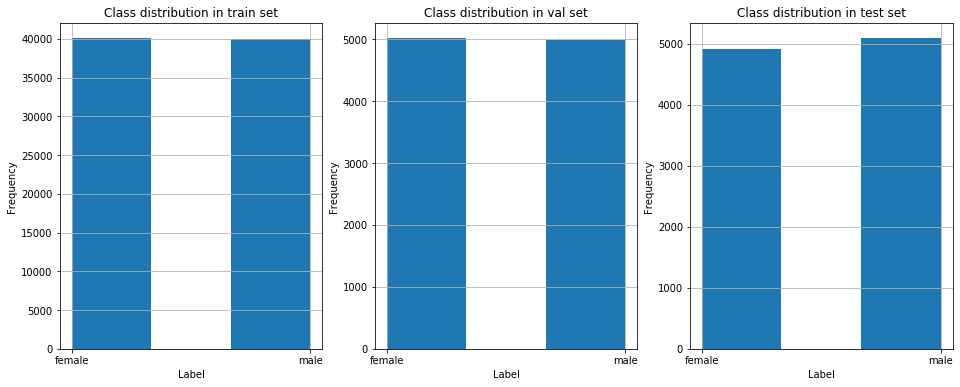

In [50]:
datasets = (train_set, val_set, test_set)
titles = ('train set', 'val set', 'test set')

fig = plt.figure(figsize=(16,6))

for i, dataset in enumerate(datasets):
    
    labels = np.array([])
    for j in range(len(dataset)):
        labels = np.append(labels, dataset[j][1])
    unique_elements = np.unique(labels)
    
    ax = fig.add_subplot(1,3,i+1)
    ax.grid()
    plt.hist(labels, bins=3)
    plt.title(f'Class distribution in {titles[i]}')
    plt.ylabel('Frequency')
    plt.xlabel('Label')
    plt.xticks(unique_elements, ['female','male'])
plt.show()

In [51]:
# функция image_show убирает нормализацию изображения и преобразует его из формата тензора в массив numpy
def image_show(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

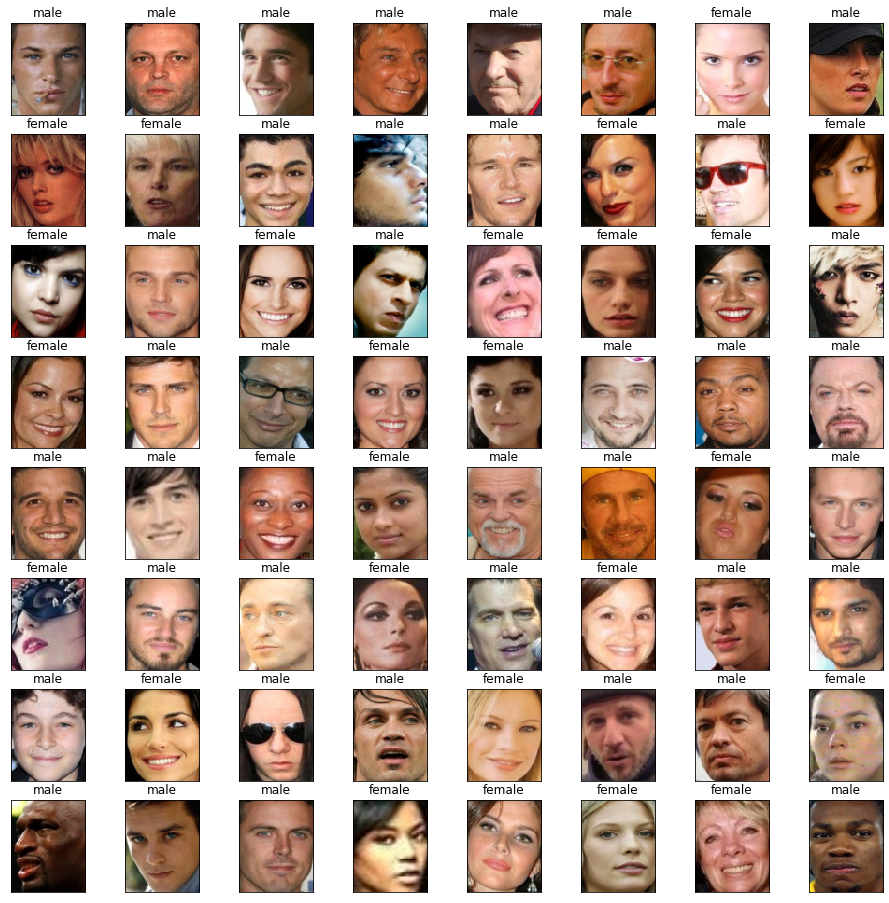

In [52]:
# первая минивыборка обучающих данных
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(16, 16))
plot_size = batch_size
for i in range(plot_size):
    ax = fig.add_subplot(8, plot_size/8, i + 1, xticks = [], yticks = [])
    ax.set_title(classes[labels[i]])
    image_show(images[i])

In [53]:
# создание модели нейронной сети
# три сверточных слоя с функциями активации ReLU 
# четыре линейных слоя с функциями активации ReLU (последний без)
# к каждому сверточному слою применяется слой пуллинга
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.pool = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(in_features = 512, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 412)
        self.fc4 = nn.Linear(in_features = 412, out_features = 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [54]:
# инициализация модели
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=2, bias=True)
)

In [55]:
# функция потерь
criterion = nn.CrossEntropyLoss()
# тип оптимизатора
optimiser = optim.Adam(model.parameters(), lr = 0.0003)

In [56]:
# обучение нейросети
# сохранение состояния нейросети на каждой эпохе
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} 

start_train = datetime.datetime.now()

for epoch in range(epochs):
    model.train()
    train_loss, train_corr = 0, 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device = device, non_blocking = True)
        labels = labels.to(device = device, non_blocking = True)
        optimiser.zero_grad() # очищаем градиенты
        outputs = model(inputs) # прямое распространение
        loss = criterion(outputs, labels) # рассчет ошибки
        loss.backward() # вычисление градиента
        optimiser.step() # градиентный шаг
        train_loss += loss.item()

        pred = outputs.argmax(1, keepdim = True)
        train_corr += pred.eq(labels.view_as(pred)).sum().item() # подсчет количества верных предсказаний

    # расчет средней ошибки и оценка качества на обучающей выборке
    train_loss /= (len(train_set) / batch_size)
    train_acc = train_corr / len(train_set)
    
    # промежуточная оценка качества на валидационной выборке
    model.eval()
    val_loss, val_corr = 0, 0
    with torch.no_grad():
        for inputs, label in val_loader:
            inputs = inputs.to(device = device, non_blocking = True)
            label = label.to(device = device, non_blocking = True)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            val_loss += loss.item()
            pred = outputs.argmax(1, keepdim = True)
            val_corr += pred.eq(label.view_as(pred)).sum().item()

    # расчет средней ошибки и оценка качества на валидационной выборке
    val_loss /= len(val_set)
    val_acc = val_corr / len(val_set)
    
    # сохранение результатов обучения
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # вывод результатов обучения за эпоху
    print('Epoch %02d - Train_loss: %.4f, Train_acc: %.4f | Val_loss: %.4f, Val_acc: %.4f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc))
    
    # сохранение параметров модели
    torch.save(model.state_dict(), 'C:/Users/atche/model/model_state-epoch-%02d-val_acc-%.4f.pth' % (epoch + 1, val_acc))
    
fit_time = datetime.datetime.now() - start_train # рассчет времени обучения
print(f'Finished, fitness time: {fit_time}')

Epoch 01 - Train_loss: 0.2543, Train_acc: 0.8908 | Val_loss: 0.1514, Val_acc: 0.9403
Epoch 02 - Train_loss: 0.1429, Train_acc: 0.9432 | Val_loss: 0.1347, Val_acc: 0.9482
Epoch 03 - Train_loss: 0.1163, Train_acc: 0.9555 | Val_loss: 0.1160, Val_acc: 0.9539
Epoch 04 - Train_loss: 0.1008, Train_acc: 0.9615 | Val_loss: 0.1219, Val_acc: 0.9527
Epoch 05 - Train_loss: 0.0872, Train_acc: 0.9663 | Val_loss: 0.1188, Val_acc: 0.9537
Epoch 06 - Train_loss: 0.0806, Train_acc: 0.9700 | Val_loss: 0.0984, Val_acc: 0.9637
Epoch 07 - Train_loss: 0.0661, Train_acc: 0.9756 | Val_loss: 0.0981, Val_acc: 0.9631
Epoch 08 - Train_loss: 0.0594, Train_acc: 0.9780 | Val_loss: 0.1034, Val_acc: 0.9607
Epoch 09 - Train_loss: 0.0508, Train_acc: 0.9811 | Val_loss: 0.1068, Val_acc: 0.9601
Epoch 10 - Train_loss: 0.0449, Train_acc: 0.9833 | Val_loss: 0.1377, Val_acc: 0.9590
Epoch 11 - Train_loss: 0.0397, Train_acc: 0.9855 | Val_loss: 0.1034, Val_acc: 0.9656
Epoch 12 - Train_loss: 0.0326, Train_acc: 0.9879 | Val_loss: 0.11

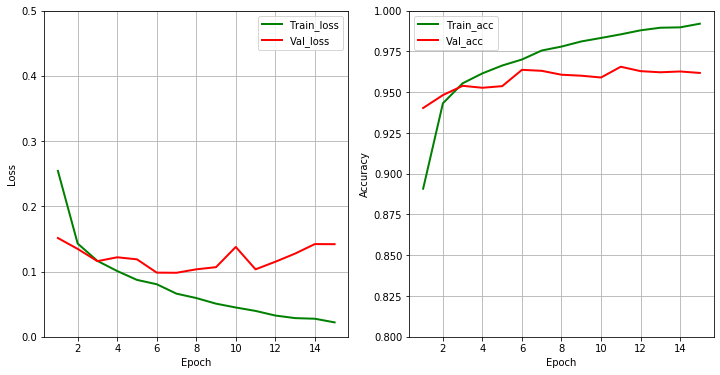

In [58]:
# визуализация процесса обучения
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
grid = [int(i) for i in range(1, len(history['train_loss']) + 1)]
ax1.plot(grid, history['train_loss'], 'g', linewidth = 2)
ax1.plot(grid, history['val_loss'], 'r', linewidth = 2)
ax1.legend(['Train_loss', 'Val_loss'])
ax1.grid()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 0.5])

ax2.plot(grid, history['train_acc'], 'g', linewidth = 2)
ax2.plot(grid, history['val_acc'], 'r', linewidth = 2)
ax2.legend(['Train_acc', 'Val_acc'])
ax2.grid()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.8, 1])

plt.show()

In [59]:
# оценка качества модели на тестовых данных
def test_model(model):
    model.eval()
    test_loss, test_corr = 0, 0

    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device = device, non_blocking = True)
            label = label.to(device = device, non_blocking = True)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            test_loss += loss.item()
            pred = outputs.argmax(1, keepdim = True)
            test_corr += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_set)
    test_acc = test_corr / len(test_set)
    print('Test_loss: %.4f, Test_accuracy: %.4f' % (test_loss, test_acc))

In [60]:
# протестируем финальную модель, прошедшую 15 эпох обучения
test_model(model)

Test_loss: 0.1465, Test_accuracy: 0.9635


In [62]:
# протестируем модель после шестой эпохи обучения
model_best_val = Net().to(device)
model_best_val.load_state_dict(torch.load('C:/Users/atche/model/model_state-epoch-06-val_acc-0.9637.pth'))
test_model(model_best_val)

Test_loss: 0.1098, Test_accuracy: 0.9595
